In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import statistics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [6]:
df_TSLA = pd.read_csv("Dataset/TSLA_2010_1d.csv")    
df_TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


# 1. Clean the Dataset

## 1.a. Rename columns

In [4]:
columns = df.iloc[0]
columns[0] = 'Date'
df.set_axis(columns, axis='columns', inplace=True)
df = df.drop(df.index[0:2])
df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
2,1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.888392984867096,0.9179689884185791,0.7837913036346436,163811200,3.965625047683716,3.96875,3.799999952316284,3.8062500953674316,3.8062500953674316,145414000
3,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9079239964485168,0.9994419813156128,0.8533555269241333,535796800,4.074999809265137,4.478125095367432,3.9523439407348633,4.46875,4.46875,322352000
4,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9034600257873535,0.9151790142059326,0.7814090847969055,512377600,4.268750190734863,4.574999809265137,4.087500095367432,4.096875190734863,4.096875190734863,349748000
5,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.919642984867096,0.9285709857940674,0.7928435206413269,778321600,3.5250000953674316,3.7562499046325684,3.4000000953674316,3.487499952316284,3.487499952316284,769148000
6,2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8482139706611633,0.8482139706611633,0.7242321372032166,767972800,3.565624952316284,3.6343750953674316,3.200000047683716,3.278125047683716,3.278125047683716,375040000


## 1.b. Set index and Convert columns


In [5]:
df.set_index("Date", inplace=True)
df.index = pd.to_datetime(df.index)
df = df.astype({'Open':'float',
                'High':'float',
                'Low':'float',
                'Close':'float',
                'Adj Close':'float',
                'Volume':'float'
                })



## 1.c. Split on stock names

In [6]:
df_TSLA = df.iloc[:, 0:6]
df_AMZN = df.iloc[:, 6:12]
df_GGL = df.iloc[:, 12:18]
df_MSFT = df.iloc[:, 18:24]
df_AAPL = df.iloc[:, 24:30]

## 1.d. Drop null values

In [7]:
df_GGL.dropna(inplace=True)
df_TSLA.dropna(inplace=True)

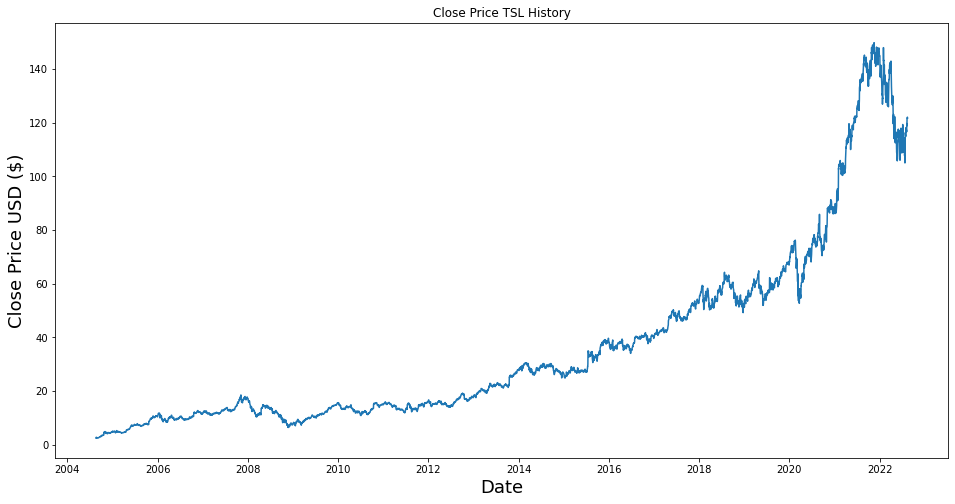

In [8]:
plt.figure(figsize=(16,8))

sns.lineplot(data=df_TSLA,
            x=df_TSLA.index,
            y='Close'
            )

plt.title("Close Price TSL History")
plt.xlabel('Date', fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()



# 2. Scale Data (Work with TSLA Stock !!!)

In [7]:
# scaler = MinMaxScaler(feature_range=(0,1))

# df_TSLA_scaled = scaler.fit_transform(np.array(df_TSLA).reshape(-1,1))
# df_GGL_scaled = scaler.fit_transform(np.array(df_GGL).reshape(-1,1))
# df_AMZN_scaled = scaler.fit_transform(np.array(df_AMZN).reshape(-1,1))
# df_MSFT_scaled = scaler.fit_transform(np.array(df_MSFT).reshape(-1,1))
# df_AAPL_scaled = scaler.fit_transform(np.array(df_AAPL).reshape(-1,1))



minmax = MinMaxScaler().fit(df_TSLA.iloc[:, 4:5].astype('float32')) # Close index
df_TSLA_log = minmax.transform(df_TSLA.iloc[:, 4:5].astype('float32')) # Close index
df_TSLA_log = pd.DataFrame(data=df_TSLA_log, index=df_TSLA.index)
df_TSLA_log.rename(columns={0:'Adj Close'}, inplace=True)
df_TSLA_log.head()

,Adj Close
0,0.001319
1,0.001309
2,0.001004
3,0.000554
4,0.000051


# 4. Preprocessing

In [9]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out   
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    return X, y

In [10]:
# Number of days into the future we want to predict
n_steps_out = 7

# choose the number of days on which to base our predictions 
nb_days = 30

n_features = 1

X, y = preprocess_multistep_lstm(df_TSLA_log.to_numpy(), nb_days, n_steps_out, n_features)

# 3. Split train and test

In [12]:
# data_TSLA = df_TSLA.filter(['Close'])
# data_GGL = df_GGL.filter(['Close'])
# data_AMZN = df_AMZN.filter(['Close'])
# data_MSFT = df_MSFT.filter(['Close'])
# data_AAPL = df_AAPL.filter(['Close'])

# dataset_TSLA = data_TSLA.values
# dataset_GGL = data_GGL.values
# dataset_AMZN = data_AMZN.values
# dataset_MSFT = data_MSFT.values
# dataset_AAPL = data_AAPL.values

#TSLA
training_data_TSLA_len = math.ceil(len(X) * 0.8)

# training_data_GGL_len = math.ceil(len(dataset_GGL) * 0.8)
# training_data_AMZN_len = math.ceil(len(dataset_AMZN) * 0.8)
# training_data_MSFT_len = math.ceil(len(dataset_MSFT) * 0.8)
# training_data_AAPL_len = math.ceil(len(dataset_AAPL) * 0.8)

X_train, y_train = X[:training_data_TSLA_len], y[:training_data_TSLA_len]
X_test, y_test = X[training_data_TSLA_len:], y[training_data_TSLA_len:]

# 5. Model LSTM

In [13]:
def vanilla_multistep_LSTM():
    model = Sequential()    
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [14]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 7)                 357       
                                                                 
Total params: 10,757
Trainable params: 10,757
Non-trainable params: 0
_________________________________________________________________


# 6. Train the model

In [15]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

Epoch 1/15
76/76 [==============================] - 2s 10ms/step - loss: 2.4689e-04 - mean_absolute_error: 0.0102 - accuracy: 0.0000e+00
Epoch 2/15
76/76 [==============================] - 1s 10ms/step - loss: 3.1958e-05 - mean_absolute_error: 0.0032 - accuracy: 0.0000e+00
Epoch 3/15
76/76 [==============================] - 1s 10ms/step - loss: 2.8674e-05 - mean_absolute_error: 0.0032 - accuracy: 0.0000e+00
Epoch 4/15
76/76 [==============================] - 1s 10ms/step - loss: 2.4999e-05 - mean_absolute_error: 0.0028 - accuracy: 0.0000e+00
Epoch 5/15
76/76 [==============================] - 1s 10ms/step - loss: 2.5588e-05 - mean_absolute_error: 0.0032 - accuracy: 0.0000e+00
Epoch 6/15
76/76 [==============================] - 1s 10ms/step - loss: 2.1414e-05 - mean_absolute_error: 0.0027 - accuracy: 0.0000e+00
Epoch 7/15
76/76 [==============================] - 1s 9ms/step - loss: 2.0074e-05 - mean_absolute_error: 0.0027 - accuracy: 0.0000e+00
Epoch 8/15
76/76 [========================

## 6.b Save Model

In [16]:
name_model = 'LSTM_epochs_15_batch_32'
model.save('Models/' + name_model)

INFO:tensorflow:Assets written to: Models/LSTM_epochs_15_batch_32\assets


INFO:tensorflow:Assets written to: Models/LSTM_epochs_15_batch_32\assets


## 6.c Load Model

In [18]:
model_test = tf.keras.models.load_model('Models/LSTM_epochs_15_batch_32')

## 7. Evaluate the model


In [17]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
19/19 [==============================] - 0s 4ms/step - loss: 0.0401 - mean_absolute_error: 0.1593 - accuracy: 0.0000e+00
Test MSE: 0.04009510204195976
Test MAE: 0.15925811231136322


# 8. Predict on test set

In [18]:
y_pred = model.predict(X_test)
# y_test_scaled = minmax.inverse_transform(y_test.reshape(len(y_pred), len(y_pred[0])))
y_pred_scaled = minmax.inverse_transform(y_pred)

19/19 [==============================] - 0s 4ms/step


In [19]:
# Moyenne sur les prédictions portant sur le même jour
diags = [statistics.mean(y_pred_scaled[::-1,:].diagonal(i)) for i in range(-y_pred_scaled.shape[0]+1,y_pred_scaled.shape[1])]
# We want the 
# diags = diags[:len(y_pred_scaled)-1]
diags = np.array(diags)

In [20]:
# df_TSLA prices for the test set
# y : [0:3018] (3019 values)
# We calculate 609 prices (1 per day)
# I check the real values on df_TSLA : [0:3055]
# I use onlly df_TSLA : [0:3018] (37 values missing because of the preprocessing step)
# test_set : [3018 - 609 + 1 :]
# Finally add 30 days (substracted in the preprocessing step) 
test_set = np.array(df_TSLA.iloc[len(X)-len(diags)+nb_days : len(X)+nb_days, 4:5].iloc[:, 0])

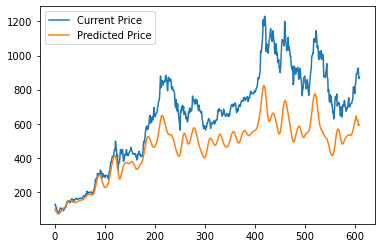

In [21]:
plt.plot(test_set)
plt.plot(diags)
plt.legend(['Current Price', 'Predicted Price'])

# 9. Simulator
1. Regarder sur 7 jours le gain maximal (calcul du max sur serie temporelle)


In [38]:
# inventory_stock = 0
initial_inventory_money = 10000
inventory_money = initial_inventory_money
max_buy = 1 # Nb max of stock to buy 
max_sell = 1 # Nb max of stock to sell

df_historic_trades = pd.DataFrame(columns={'inventory_money',
                                           'buy_day',
                                           'sell_day', 
                                           'buy_price',
                                           'sell_price'
                                          }) 

def buy(profit, inventory_money, df_historic_trades): # profit : [value_profit_predicted, buy_day, sell_day]
    
    # Check if there is enough money to buy
    predicted_price = profit[0]
    buy_day = profit[1]
    sell_day = profit[2]
    buy_price = test_set[buy_day]
    sell_price = test_set[sell_day]

    # Not enough money
    if inventory_money < buy_price * max_buy :
        print(f"Day {buy_day} : Total balance : {inventory_money}, Not enough money to buy {max_buy} stock(s) at {buy_price}$")
    
    else :
        inventory_money += (sell_price * max_sell) -(buy_price * max_buy)
        # inventory_stock += max_buy
        # df_historic_trades = df_historic_trades.append({'inventory_money' : inventory_money, 
        #                                                 'buy_day' : buy_day, 
        #                                                 'buy_price' : buy_price, 
        #                                                 'sell_day' : sell_day, 
        #                                                 'sell_price' : sell_price
        #                                                 },
        #                                                 ignore_index=True
        #                                               )

        new_row = pd.DataFrame({'inventory_money' : inventory_money, 
                                    'buy_day' : buy_day, 
                                    'buy_price' : buy_price, 
                                    'sell_day' : sell_day, 
                                    'sell_price' : sell_price
                                    },
                                    index=[0]
                                  )
        # df_historic_trades = pd.concat([new_row,df_historic_trades.loc[:]]).reset_index(drop=True)
        df_historic_trades = pd.concat([df_historic_trades, new_row], axis=0, ignore_index=True)

    return inventory_money, df_historic_trades

i = 0
while i + n_steps_out < len(diags) :
    
    # print(f"Day {i} - Balance : {inventory_money}, Profits : {((inventory_money/initial_inventory_money) - 1) * 100:.2f}%")

    sell_day = None
    profit = [diags[i+1]-diags[i], i, i+1] # [value_profit_predicted, buy_day, sell_day]

    # Find the max difference value in the interval [i : i+7]
    for j in range(i, i+n_steps_out-1):
        for h in range(j+1, i+n_steps_out):
            profit = [diags[h]-diags[j], j, h] if diags[h]-diags[j] > profit[0] else profit
            sell_day = h
            
    inventory_money, df_historic_trades = buy(profit, inventory_money, df_historic_trades)

    i = sell_day



In [48]:
type(df_TSLA.loc[:10])

pandas.core.frame.DataFrame

In [28]:
# Retrieve Buy/Sell point of test_set
buy_days = []
sell_days = []
buy_prices = []
sell_prices = []

for day in range(len(df_historic_trades.buy_day)):
    buy_days.append(df_historic_trades.loc[day, 'buy_day'])
    sell_days.append(df_historic_trades.loc[day, 'sell_day'])
    
    buy_prices.append(df_historic_trades.loc[day, 'buy_price'])
    sell_prices.append(df_historic_trades.loc[day, 'sell_price'])
    

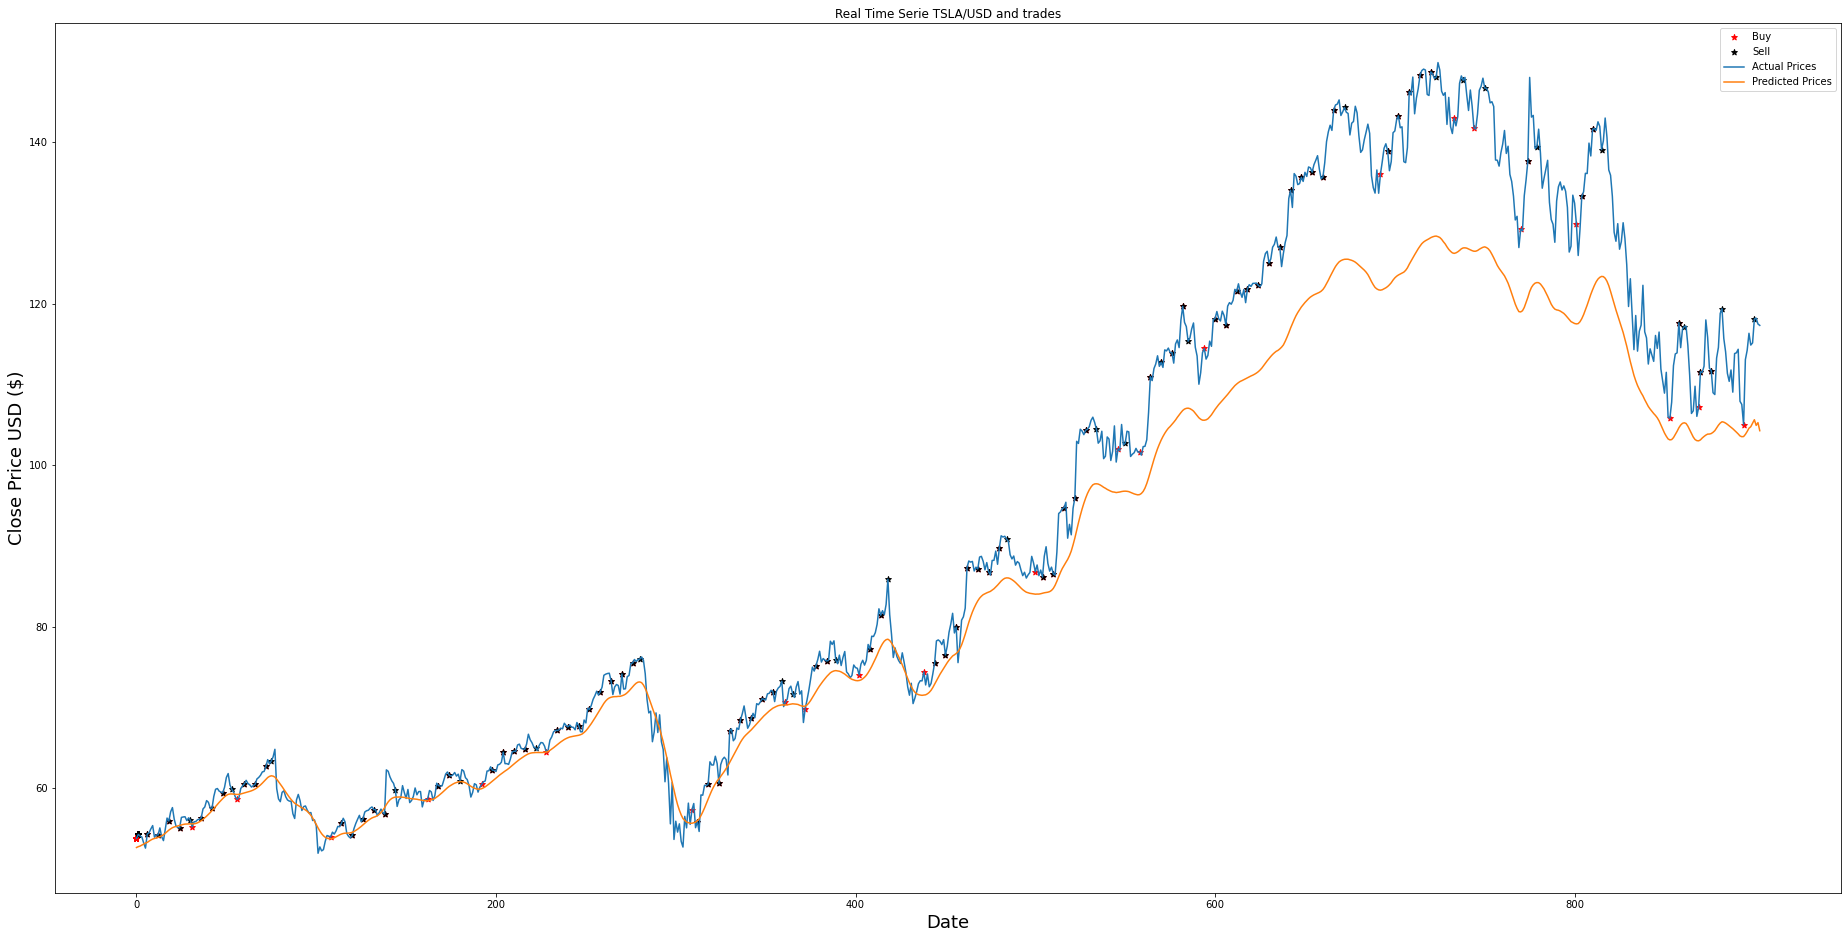

In [29]:
plt.figure(figsize=(32,16))

plt.title("Real Time Serie TSLA/USD and trades")
plt.xlabel('Date', fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)

# Plot Buy/Sell Trades
plt.scatter(x=buy_days, y=buy_prices, marker='*', color='red', label='Buy')
plt.scatter(x=sell_days, y=sell_prices, marker='*', color='black', label='Sell')

# Plot actual/predicted prices
plt.plot(test_set, label='Actual Prices')
plt.plot(diags, label='Predicted Prices')

plt.legend()
plt.show()